<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

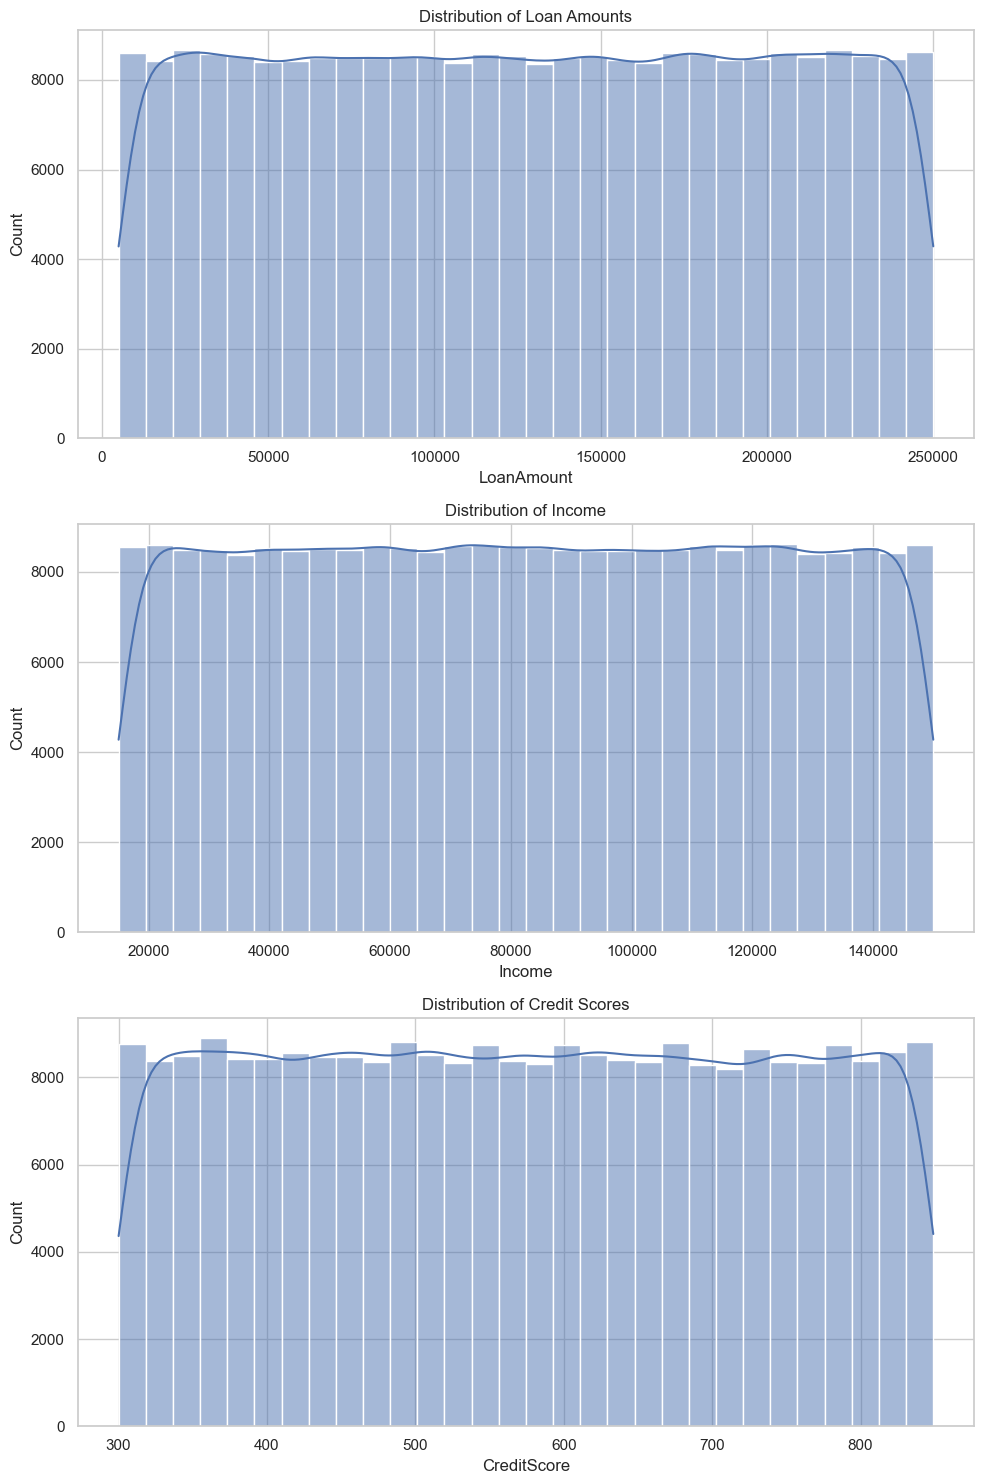

Series([], dtype: int64)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
loan_data = pd.read_csv('Loan_default.csv')

# Display basic info and the first few rows
print(loan_data.info())
print(loan_data.head())

# Set seaborn style for visualization
sns.set(style="whitegrid")

# Plotting histograms for several key features
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.histplot(loan_data['LoanAmount'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Loan Amounts')

sns.histplot(loan_data['Income'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Income')

sns.histplot(loan_data['CreditScore'], bins=30, kde=True, ax=ax[2])
ax[2].set_title('Distribution of Credit Scores')

plt.tight_layout()
plt.show()

# Check for missing values
missing_values = loan_data.isnull().sum()
print(missing_values[missing_values > 0])




In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the data
loan_data = pd.read_csv('Loan_default.csv')

# One-hot encode categorical variables
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Ensure dense output
encoded_features = encoder.fit_transform(loan_data[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Combine encoded features with numerical features
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
loan_data_numerical = loan_data[numerical_features]
loan_data_prepared = pd.concat([loan_data_numerical, encoded_df], axis=1)

# Define the target variable
y = loan_data['Default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(loan_data_prepared, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
X_train.shape

(204277, 24)

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Initializing LDA
lda = LDA(n_components=None)  # Let LDA decide the optimal number of components based on the data

# Fitting LDA on the training data
X_train_lda = lda.fit_transform(X_train, y_train)  # Fit to data, then transform it

# Transforming the test data using the same LDA fit
X_test_lda = lda.transform(X_test)  # Apply the same transformation to the test data

print("Original number of features:", X_train.shape[1])
print("Reduced number of features after LDA:", X_train_lda.shape[1])


Original number of features: 24
Reduced number of features after LDA: 1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train_lda, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_lda)

# Evaluating the model
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

conf_matrix


array([[45008,   131],
       [ 5731,   200]], dtype=int64)

In [8]:
print(report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.60      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.85      0.89      0.84     51070



In [9]:
import pymc as pm
import numpy as np

with pm.Model() as logistic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=-10, sigma=10)
    betas = pm.Normal("betas", mu=-1, sigma=1.5, shape=X_train_lda.shape[1])
    
    # Expected value of outcome: logistic function applied to the linear model
    logits = alpha + pm.math.dot(X_train_lda, betas)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", logit_p=logits, observed=y_train)
    
    # Sample from the posterior using the No-U-Turn Sampler (NUTS)
    trace = pm.sample(300, tune=300, target_accept=0.95, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas]


Output()

Sampling 4 chains for 300 tune and 300 draw iterations (1_200 + 1_200 draws total) took 310 seconds.


In [10]:
import numpy as np

# Check if there are parameters with no variation
for var in trace.posterior.data_vars:
    var_data = trace.posterior[var].values
    print(f'{var}: unique values = {np.unique(var_data)}')


alpha: unique values = [-2.40530613 -2.40464559 -2.4034384  ... -2.35238057 -2.35192093
 -2.35190425]
betas: unique values = [0.92990304 0.93046463 0.93225216 ... 0.97456744 0.97629099 0.97931885]


In [11]:
import arviz as az

# Summary of the trace to check for convergence issues
summary = az.summary(trace)
print(summary)


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -2.378  0.009  -2.393   -2.360        0.0      0.0     602.0   
betas[0]  0.954  0.008   0.941    0.969        0.0      0.0     506.0   

          ess_tail  r_hat  
alpha        605.0   1.00  
betas[0]     663.0   1.01  


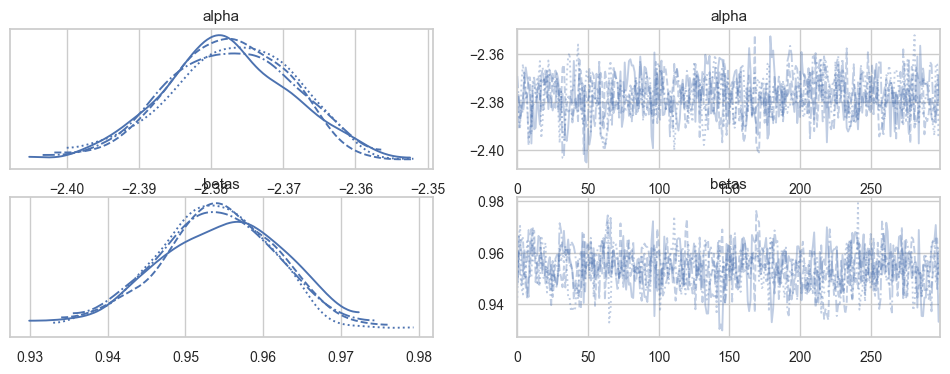

In [12]:
import arviz as az

# Generate trace plots for the parameters
az.plot_trace(trace)
plt.show()


In [13]:
import numpy as np
from scipy.special import expit
from sklearn.metrics import accuracy_score

# Compute the mean of the posterior samples
alpha_mean = np.mean(trace.posterior['alpha'].values)
betas_mean = np.mean(trace.posterior['betas'].values, axis=(0, 1))

# Predict on the test set using the mean coefficients
logits = alpha_mean + np.dot(X_test_lda, betas_mean)
probs = expit(logits)  # More stable than using np.exp manually
predictions = (probs >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 88.52%
